## Practical 3a - Using Spark SQL for Data Preparation (Solution)
Any serious data scientist or data modeler must be acquainted with the dataset before starting any modeling. In this exercise, we shall practice doing some data exploration. We shall use the dataset `ccFraud.csv.gz` which is a simulated dataset on credit card fraud. The data is approximately 200MB and contains the following fields (each separated by a comma):

```
custID: A unique identifier for each customer
gender: Gender of the customer
state: State in the United States where the customer lives
cardholder: Number of credit cards the customer holds
balance: Balance on the credit card
numTrans: Number of transactions to date
numIntlTrans: Number of international transactions to date
creditLine: The financial services corporation, such as Visa, MasterCard, and American Express
fraudRisk: Binary variable, 1 means customer being frauded, 0 means otherwise
```
The following are the first 10 lines of the file:
```
"custID","gender","state","cardholder","balance","numTrans","numIntlTrans","creditLine","fraudRisk"
1,1,35,1,3000,4,14,2,0
2,2,2,1,0,9,0,18,0
3,2,2,1,0,27,9,16,0
4,1,15,1,0,12,0,5,0
5,1,46,1,0,11,16,7,0
6,2,44,2,5546,21,0,13,0
7,1,3,1,2000,41,0,1,0
8,1,10,1,6016,20,3,6,0
9,2,32,1,2428,4,10,22,0
```
Let us start by loading the dataset:
```python
fraudDF = spark.read.csv("/home/training/data/ccFraud.csv.gz", inferSchema=True, header=True)
```

In [6]:
fraudDF = spark.read.csv("/home/training/data/ccFraud.csv.gz", inferSchema=True, header=True)

### Descriptive Statistics
For a better understanding of the categorical columns, we will count the frequencies of their values using the `groupby` method. For example, count the frequencies of the `gender` column as follows:
```python
fraudDF.groupby('gender').count().show()
```
Notice that the gender is fairly imbalanced. What you would expect to see is an equal distribution for both genders.

In [7]:
fraudDF.groupby('gender').count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



For the truly numerical features, we can use the `describe` method:
```python
numerical = ['balance', 'numTrans', 'numIntlTrans']
desc = fraudDF.describe(numerical)
desc.show()
```
Notice that:
- All the features are positively skewed. The maximum values are a number of times larger than the mean.
- The coefficient of variation (the ratio of mean to standard deviation) is very high (close or greater than 1), suggesting a wide spread of observations.

In [8]:
numerical = ['balance', 'numTrans', 'numIntlTrans']
desc = fraudDF.describe(numerical)
desc.show()

+-------+-----------------+------------------+-----------------+
|summary|          balance|          numTrans|     numIntlTrans|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.847309737077|26.553781024522852|8.602970115863767|
|    min|                0|                 0|                0|
|    max|            41485|               100|               60|
+-------+-----------------+------------------+-----------------+



Let us find the skewness of the `balance` feature:
```python
fraudDF.agg( {'balance': 'skewness'} ).show()
```
A skewness of 0 means that the data are perfectly symmetrical.

In [9]:
fraudDF.agg( {'balance': 'skewness'} ).show()

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552995033|
+------------------+



### Correlations
Calculating correlations is very easy once your data is in a DataFrame. However, the `corr` method supports only the Pearson correlation coefficient at the moment and hence, it can only calculate pairwise correlations. Nonetheless, it is still useful for data exploration. Let us create a correlations matrix using the three numerical attributes as follows (it might take some time to compute the correlation matrix due to the large amount of data):
```python
n_numerical = len(numerical)
corr = []

for i in range(0, n_numerical):
    temp = [None] * i
    for j in range(i, n_numerical):
        temp.append(fraudDF.corr(numerical[i], numerical[j]))
    corr.append(temp)

# print the correlation matrix in a nicely formatted table
from tabulate import tabulate
print(tabulate(corr, headers=numerical, showindex=numerical, tablefmt="fancy_grid", numalign="center"))
```
Notice that the correlations between the numerical features in the credit card fraud dataset are pretty non-existent. Thus, all these features can be used in our models.

In [10]:
n_numerical = len(numerical)
corr = []

for i in range(0, n_numerical):
    temp = [None] * i
    for j in range(i, n_numerical):
        temp.append(fraudDF.corr(numerical[i], numerical[j]))
    corr.append(temp)
    
# print the correlation matrix in a nicely formatted table
from tabulate import tabulate
print(tabulate(corr, headers=numerical, showindex=numerical, tablefmt="fancy_grid", numalign="center"))

╒══════════════╤═══════════╤═════════════╤════════════════╕
│              │  balance  │  numTrans   │  numIntlTrans  │
╞══════════════╪═══════════╪═════════════╪════════════════╡
│ balance      │     1     │ 0.000445231 │  0.000271399   │
├──────────────┼───────────┼─────────────┼────────────────┤
│ numTrans     │           │      1      │  -0.000280571  │
├──────────────┼───────────┼─────────────┼────────────────┤
│ numIntlTrans │           │             │       1        │
╘══════════════╧═══════════╧═════════════╧════════════════╛


### Data Visualization
Since data visualization is already covered in an earlier subject, we shall not be spending too much time on this topic in this subject. You are free to use any tools e.g. Excel, QlikView, Power BI etc to do your data visualizations. For this exercise, we shall show you how you can use the `matplotlib` library to create a simple histogram programmatically using Python. If you are interested in generating those visualizations covered in the lecture programmatically using Python, please refer to the examples we provided in P03c.

Start by loading the relevant modules and setting them up as follows:
```
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
```
The `%matplotlib inline` will make every chart generated with `matplotlib` appears within the notebook and not as a separate window.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Now, let us create a histogram of the `balance` column as follows:
```
bal_list = [i[0] for i in fraudDF.select("balance").collect()]
plt.title("Histogram of 'balance'")
plt.hist(bal_list, bins = 20)
plt.show()
```
First, we collect all the `balance` values into a single list. Then, we set the title of the histogram and called the `hist` method to create a histogram with 20 bins. The `show` method displays the histogram graphically in the notebook. 

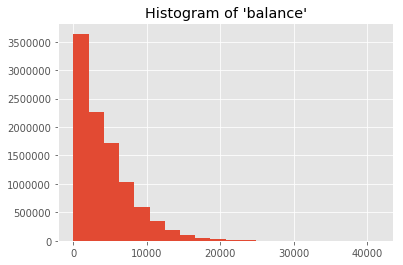

In [12]:
bal_list = [i[0] for i in fraudDF.select("balance").collect()]
plt.title("Histogram of 'balance'")
plt.hist(bal_list, bins = 20)
plt.show()